In [ ]:
# Load required libraries
import json
import numpy as np
import pandas as pd
import time
from scipy.stats import percentileofscore
import seaborn as sns
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt

In [1]:
# Read user data
res = []
with open('user.json') as f:
    for line in f:
        res.append(json.loads(line))

user = pd.DataFrame(res)

In [5]:
# Read review data
res = []
with open('review.json') as f:
    for line in f:
        res.append(json.loads(line))
review = pd.DataFrame(res)

In [8]:
elite_users = user[['user_id', 'elite']][user['elite'] != '']

elite_users = elite_users.reset_index()[['user_id', 'elite']]

elite_users['elite'] = [elite_users['elite'][i].split(',') for i in range(elite_users.shape[0])]

review['date'] = pd.to_datetime(review['date'])

review['year'] = [elem.year for elem in review['date']]

In [142]:
# Obtain a sample of 300 elite reviews
result = []
for i in range(100):
    for j in range(len(elite_users['elite'][i])):
        uid = elite_users['user_id'][i]
        year = int(elite_users['elite'][i][j])
        influencer_review = review.loc[np.logical_and(review['user_id']==uid,review['year']==year),]
        if not influencer_review.empty:
            result.append(influencer_review[['business_id', 'date', 'stars']])

r = pd.concat(result, axis=0)
r = r.sample(300, random_state=100)
r = r.reset_index()[['business_id', 'date', 'stars']]

In [ ]:
# For each elite review of a business, find all reviews of the business before and after 1 month
# Compare to reviews happening during the same time interval for other businesses
res = []
res_all = []
for i in range(300):
    bid = r['business_id'][i]
    d = r['date'][i]
    before = review['stars'][np.logical_and(review['business_id']==bid,
                                            np.logical_and(d - review['date'] > pd.to_timedelta(0, unit='second'),
                                            d - review['date'] < pd.to_timedelta(30, unit='day')))]
    before_all = review[['stars', 'business_id']][np.logical_and(d - review['date'] > pd.to_timedelta(0, unit='second'),
                                                d - review['date'] < pd.to_timedelta(30, unit='day'))]
    after = review['stars'][np.logical_and(review['business_id']==bid,
                                          np.logical_and(review['date'] - d > pd.to_timedelta(0, unit='second'),
                                          review['date'] - d < pd.to_timedelta(30, unit='day')))]
    after_all = review[['stars', 'business_id']][np.logical_and(review['date'] - d > pd.to_timedelta(0, unit='second'),
                                               review['date'] - d < pd.to_timedelta(30, unit='day'))]
    before_all = before_all.set_index('business_id')
    after_all = after_all.set_index('business_id')
    tmp = []
    for j in range(np.min([after_all.shape[0], 1000])):
        busi_id = after_all.index[j]
        tmp2 = []
        if busi_id in before_all.index:
            try:
                tmp2.extend([np.mean(after_all.loc[busi_id, 'stars']), len(after_all.loc[busi_id, 'stars'])])
            except:
                tmp2.extend([np.mean(after_all.loc[busi_id, 'stars']), 1])
            try:
                tmp2.extend([np.mean(before_all.loc[busi_id, 'stars']), len(before_all.loc[busi_id, 'stars'])])
            except:
                tmp2.extend([np.mean(before_all.loc[busi_id, 'stars']), 1])
            tmp.append(tmp2)
    res.append([np.mean(after), np.mean(before), len(after), len(before)])
    res_all.append(tmp)

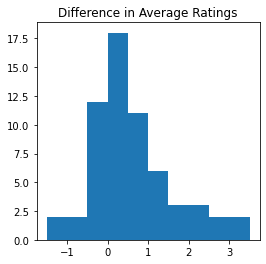

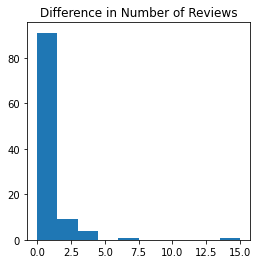

In [239]:
# Changes in number of all reviews of a business before and after an elite review
plt.figure(figsize=(4, 4))
plt.hist([elem[0] - elem[1] for elem in res if elem[1] < 1e6 and elem[0] < 1e6 and elem[1] < 4])
plt.title('Difference in Average Ratings')
plt.show()
plt.figure(figsize=(4,4))
plt.hist([elem[2] - elem[3] for elem in res if elem[3] < 1])
plt.title('Difference in Number of Reviews')
plt.show()

In [241]:
print(np.mean([elem[0] - elem[1] for elem in res if elem[1] < 1e6 and elem[0] < 1e6 and elem[1] < 4]))
print(np.mean([elem[2] - elem[3] for elem in res if elem[3] < 1]))

0.5204172392338796
0.7169811320754716


In [218]:
# Paired t-test to test whether the changes are significant.
# The tests are constrained to businesses with average rating in previous month below 4
# or with 0 total number of reviews in previous month
print(ttest_1samp([elem[0] - elem[1] for elem in res if elem[1] < 1e6 and elem[0] < 1e6 and elem[1] < 4], 0))
print(ttest_1samp([elem[2] - elem[3] for elem in res if elem[3] < 1], 0))

Ttest_1sampResult(statistic=4.124767047777782, pvalue=0.00011599974210436121)
Ttest_1sampResult(statistic=4.179683550224914, pvalue=6.059023291962873e-05)


63.59305432200181

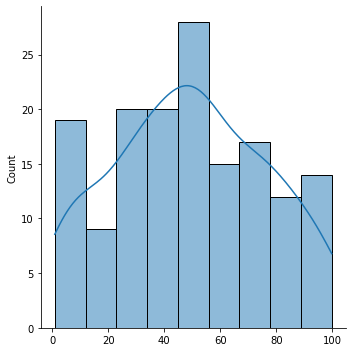

<Figure size 288x288 with 0 Axes>

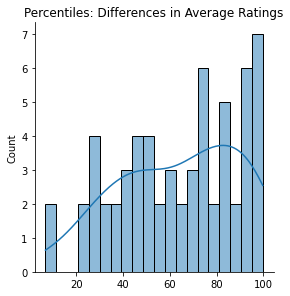

In [263]:
# For each elite review, calculate the difference in average ratings. 
# Compare to differences in other businesses.
result = [elem[0] - elem[1] for elem in res]
result_all = [[elem2[0] - elem2[2] for elem2 in elem] for elem in res_all]

percentiles = []
for i in range(300):
    percentiles.append(percentileofscore(result_all[i], result[i]))
sns.displot(percentiles, kde=True)

# If we only focus on businesses with average rating in the previous month below 4 stars
plt.figure(figsize=(4,4))
sns.displot(pd.Series(percentiles)[pd.Series([elem[1] <4 and elem[0] < 1e6 for elem in res])], kde = True, bins=20, 
            height=4, )
plt.title('Percentiles: Differences in Average Ratings')
np.mean(pd.Series(percentiles)[pd.Series([elem[1] <4 and elem[0] < 1e6 for elem in res])])

In [222]:
# The null hypothesis is that the distribution of percentiles should follow a normal distribution with mean 50.
from scipy import stats
print(stats.kstest(pd.Series(percentiles)[pd.Series([elem[1] < 4 and elem[0] < 1e6 for elem in res])], 
                   stats.norm.cdf))

# A 1-sample t-test
print(ttest_1samp(pd.Series(percentiles)[pd.Series([elem[1] < 4 and elem[0] < 1e6 for elem in res])], 50))

KstestResult(statistic=0.9999999999937714, pvalue=0.0)
Ttest_1sampResult(statistic=4.118876996754513, pvalue=0.00011833171119226735)


Text(0.5, 1.0, 'Percentiles: Differences in Number of Reviews')

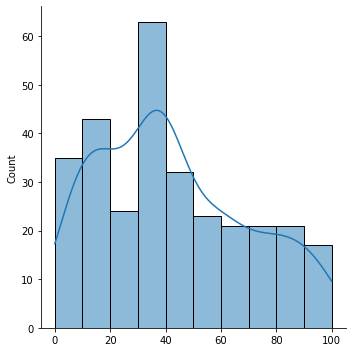

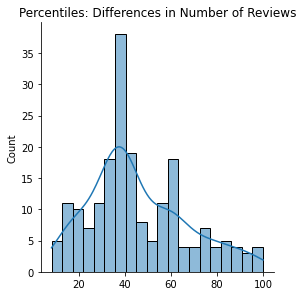

In [264]:
# For each elite review, calculate the difference in the number of reviews. 
# Compare to differences in other businesses.
result = [elem[2] - elem[3] for elem in res]
result_all = [[elem2[1] - elem2[3] for elem2 in elem] for elem in res_all]
percentiles = []
for i in range(300):
    percentiles.append(percentileofscore(result_all[i], result[i]))
sns.displot(percentiles, kde=True)

# If we only focus on businesses with average number of reviews in the previous month below 3
sns.displot(pd.Series(percentiles)[pd.Series([elem[3] < 3 for elem in res])], kde = True, bins=20, height=4)
plt.title('Percentiles: Differences in Number of Reviews')